In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
df = pd.read_csv("ds_jobs.csv")

df.head()

,job_title,job_skills
0,Senior Machine Learning Engineer,"Machine Learning, Programming, Python, Scala, ..."
1,"Principal Software Engineer, ML Accelerators","C++, Python, PyTorch, TensorFlow, MXNet, CUDA,..."
2,Senior ETL Data Warehouse Specialist,"ETL, Data Integration, Data Transformation, Da..."
3,Senior Data Warehouse Developer / Architect,"Data Lakes, Data Bricks, Azure Data Factory Pi..."
4,Lead Data Engineer,"Java, Scala, Python, RDBMS, NoSQL, Redshift, S..."


In [4]:
df.shape

(26361, 2)

# EDA

In [5]:
df.info() #basic info check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26361 entries, 0 to 26360
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   job_title   26360 non-null  object
 1   job_skills  26350 non-null  object
dtypes: object(2)
memory usage: 412.0+ KB


In [6]:
df.describe() #statistical analysis

,job_title,job_skills
count,26360,26350
unique,12227,25000
top,Data Scientist,"Big Data,Business Intelligence,Data analysis,E..."
freq,1137,12


1. The first column represents job titles, and "Data Scientist" is the most common job title.
2. The second column represents skills or areas of expertise. The most common combination occurs 12 times.
3. There are some missing values in both columns since the count is less than the total number of entries.

In [7]:
df.isnull().sum() #checking missing values

job_title      1
job_skills    11
dtype: int64

In [8]:
df.duplicated().sum() #checking duplicates

904

# Data Cleaning

### Handling Missing Values

In [9]:
df1 = df.copy()

In [10]:
df1.dropna(axis=0, inplace = True)

In [11]:
df1.isnull().sum()

job_title     0
job_skills    0
dtype: int64

In [12]:
df1.describe()

,job_title,job_skills
count,26349,26349
unique,12220,24999
top,Data Scientist,"Big Data,Business Intelligence,Data analysis,E..."
freq,1136,12


### Handling Duplicates

In [13]:
df1.drop_duplicates(inplace=True)
df1.shape

(25445, 2)

In [14]:
df1.duplicated().sum()

0

# Data Wrangling

In [15]:
def is_data_scientist(title):
    if "data scientist" in title.lower():
        return 0
    elif "data analyst" in title.lower():
        return 1
    elif "data engineer" in title.lower():
        return 2
    else:
        return 3

In [16]:
df1["target"] = df1['job_title'].apply(is_data_scientist)

Defining target with distinct categories for classification.

In [17]:
df1['target'].value_counts()

target
3    10539
2     6367
0     4553
1     3986
Name: count, dtype: int64

In [18]:
df1.drop('job_title',axis=1, inplace=True)

df1.shape

(25445, 2)

In [19]:
df2 = df1[df1['target']!=3]

df2.shape

(14906, 2)

Removing rows that don't belong any of the three classes.

In [20]:
def text_count(df,target):
    text_dict = {}
    for row in df.iterrows():
        if(row[1][1] == target):
            
            text = row[1][0].split(",")
            for word in text:
                word = word.strip()
                if text != " ":
                    if word.lower() not in text_dict.keys():
                        text_dict.update({f"{word.lower()}":1})
                    else:
                        text_dict[f"{word.lower()}"]+=1

    return text_dict

In [21]:
text_dict_0 = text_count(df2,0)
text_dict_1 = text_count(df2,1)
text_dict_2 = text_count(df2,2)

In [22]:
def in_demand(text_dict):
    in_demand_skills = {}
    
    for key in text_dict:
        if text_dict[key] > 400:
            in_demand_skills[key] = text_dict[key]
        
    return in_demand_skills

In [23]:
in_demand_skills_0= in_demand(text_dict_0)
in_demand_skills_0

{'data science': 2146,
 'machine learning': 2950,
 'artificial intelligence': 543,
 'data analysis': 1016,
 'data visualization': 967,
 'data mining': 780,
 'r': 1493,
 'python': 2902,
 'pytorch': 436,
 'tensorflow': 499,
 'statistics': 879,
 'data analytics': 489,
 'tableau': 612,
 'sql': 1772,
 'communication': 469,
 'computer science': 723,
 'deep learning': 630,
 'big data': 439,
 'predictive modeling': 416,
 'natural language processing': 460,
 'java': 443,
 'hadoop': 478,
 'spark': 604,
 'aws': 620}

In [24]:
in_demand_skills_1= in_demand(text_dict_1)
in_demand_skills_1

{'data analysis': 2306,
 'communication': 710,
 'reporting': 418,
 'excel': 766,
 'tableau': 1193,
 'sql': 1836,
 'r': 846,
 'power bi': 833,
 'business intelligence': 580,
 'data visualization': 1463,
 'machine learning': 461,
 'data mining': 628,
 'python': 1326,
 'data modeling': 412,
 'data management': 613,
 'project management': 494,
 'data analytics': 686,
 'analytical skills': 443,
 'statistics': 432,
 'data analyst': 405}

In [25]:
in_demand_skills_2= in_demand(text_dict_2)
in_demand_skills_2

{'java': 1516,
 'scala': 1170,
 'python': 3132,
 'nosql': 721,
 'redshift': 615,
 'snowflake': 998,
 'hadoop': 1013,
 'tableau': 427,
 'sql': 2234,
 'data engineering': 1543,
 'data analytics': 453,
 'data warehousing': 948,
 'cloud computing': 542,
 'data governance': 414,
 'machine learning': 883,
 'business intelligence': 424,
 'data visualization': 426,
 'data quality': 445,
 'data pipelines': 687,
 'data science': 470,
 'data analysis': 526,
 'spark': 1626,
 'airflow': 769,
 'azure': 1073,
 'databricks': 404,
 'kafka': 966,
 'cassandra': 416,
 'pyspark': 639,
 'etl': 1025,
 'agile': 938,
 'data modeling': 832,
 'aws': 1878,
 'hive': 740,
 'emr': 460,
 'mysql': 552,
 'big data': 1078,
 'communication': 417,
 'gcp': 451,
 'computer science': 673,
 'git': 427,
 'devops': 444,
 'cloud': 481,
 'it skills': 862}

In [26]:
def word_cloud(text_dict):
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(text_dict)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

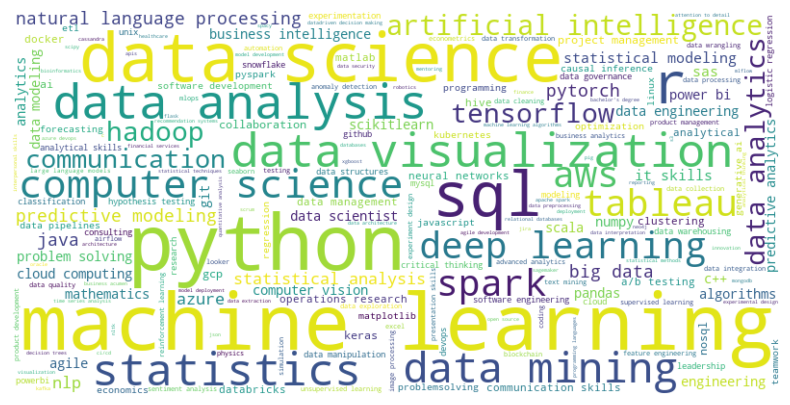

In [27]:
word_cloud(text_dict_0)

#### It can be clearly seen that skills like python,r,machine learning,statistics,sql,deep learning, data viz etc are bigger and prominant for target class 0 i.e. Data Scientist.

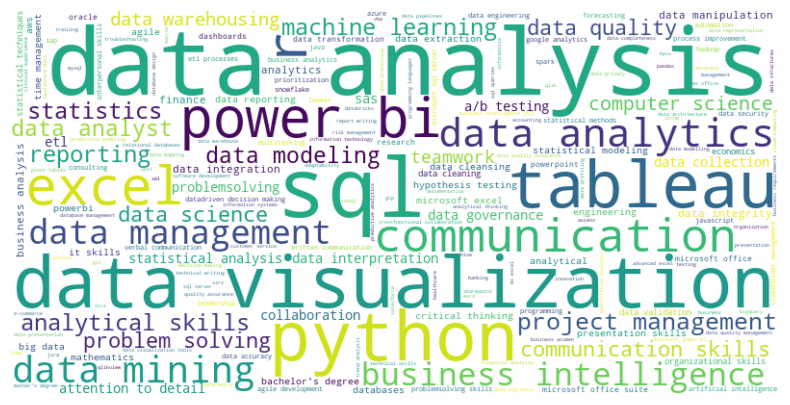

In [28]:
word_cloud(text_dict_1)

#### It can be clearly seen that skills like sql, power bi, tableau, data analysis, excel etc are bigger and prominant for target  class 1 i.e. Data Analyst

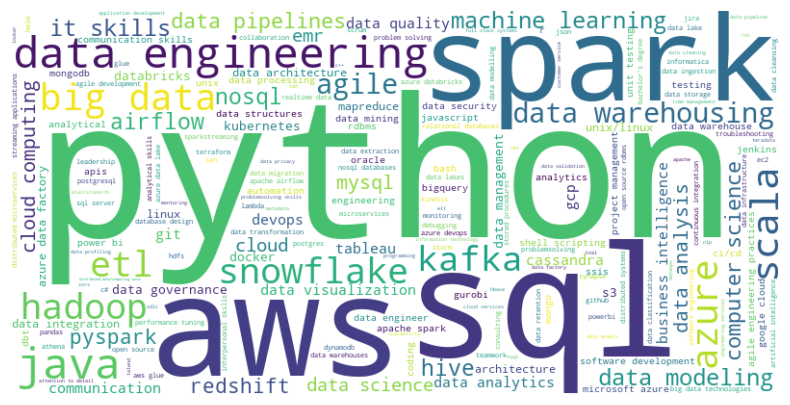

In [29]:
word_cloud(text_dict_2)

#### It can be clearly seen that skills like python,sql,aws,snowflake,spark,scala,hadoop,etl,data warehousing etc are bigger and prominant for target class 2 i.e. Data Engineer

# Model Building

In [30]:
df2.head()

,job_skills,target
4,"Java, Scala, Python, RDBMS, NoSQL, Redshift, S...",2
5,"Data Warehouse (DW), Extract/Transform/Load (E...",2
8,"Problem solving, Data analysis, Predictive ana...",1
10,"SQL, Database Administration, Advanced Statist...",1
15,"Data Engineering, Data Analytics, Data Warehou...",2


In [31]:
X_train,X_test,y_train,y_test = train_test_split(df2.job_skills,df2.target,stratify=df2.target,test_size=0.20,random_state=42)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((11924,), (2982,), (11924,), (2982,))

In [32]:
cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train)
X_test_vec = cv.transform(X_test)
X_train_vec.shape,X_test_vec.shape

((11924, 8713), (2982, 8713))

Converted text in job_skills into a form of count matrix.

In [33]:
X_train_df = pd.DataFrame(X_train_vec.toarray(), columns = cv.get_feature_names_out())

In [34]:
X_train_df.head()

,00,00pm,01m,02,03,08,10,100,100000,1013,...,zone,zones,zookeeper,zoom,zorin,zscaler,zsh,zuheatwb0l,zuora,zyputer
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_vec)
X_test_tfidf = tfidf.transform(X_test_vec)
X_train_tfidf.shape,X_test_tfidf.shape

((11924, 8713), (2982, 8713))

In [36]:
X_train_df1 = pd.DataFrame(X_train_tfidf.toarray(), columns = cv.get_feature_names_out())
X_train_df1.head()

,00,00pm,01m,02,03,08,10,100,100000,1013,...,zone,zones,zookeeper,zoom,zorin,zscaler,zsh,zuheatwb0l,zuora,zyputer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Measuring importance of terms relative to the entire corpus.

In [37]:
smote = SMOTE()

X_train_resampled, y_train_resampled  = smote.fit_resample(X_train_tfidf,y_train)

X_train_resampled.shape, y_train_resampled.shape

((15279, 8713), (15279,))

In [38]:
y_train_resampled.value_counts()

target
0    5093
1    5093
2    5093
Name: count, dtype: int64

Balancing data across all categories to avoid any bias during training.

### Finding best classifier

In [39]:
def best_classifier(model_dict):
    for name,model in model_dict.items():
        m = model.fit(X_train_resampled, y_train_resampled)
        y_hat = m.predict(X_test_tfidf)
        score = cross_val_score(m,X_train_resampled, y_train_resampled,cv=10)
        
        print(name)
        print('*'*100)
        print(f'Score for {name} is: {score.mean()}')
        
        sns.heatmap(confusion_matrix(y_test,y_hat), annot =True, fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.show()
        
        cr = classification_report(y_test,y_hat)
        print(cr)
        
    return m

Logistic_Regression
****************************************************************************************************
Score for Logistic_Regression is: 0.8936476323215284


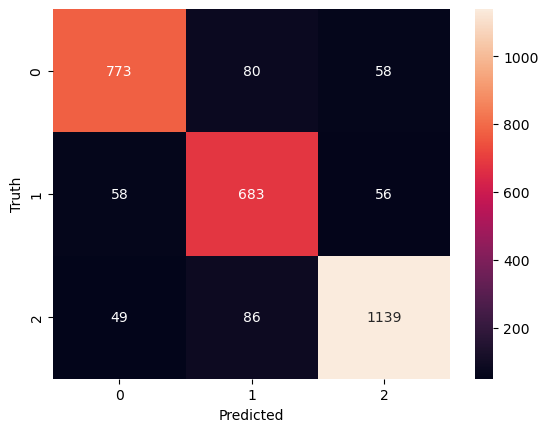

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       911
           1       0.80      0.86      0.83       797
           2       0.91      0.89      0.90      1274

    accuracy                           0.87      2982
   macro avg       0.86      0.87      0.86      2982
weighted avg       0.87      0.87      0.87      2982



In [40]:
m1 = best_classifier({'Logistic_Regression': LogisticRegression(max_iter=10000)})

SVM
****************************************************************************************************
Score for SVM is: 0.9193696276790888


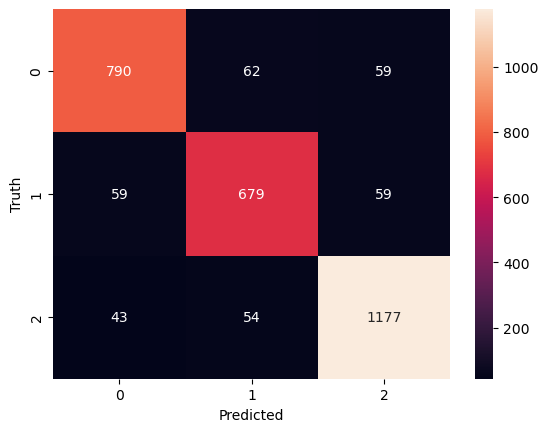

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       911
           1       0.85      0.85      0.85       797
           2       0.91      0.92      0.92      1274

    accuracy                           0.89      2982
   macro avg       0.88      0.88      0.88      2982
weighted avg       0.89      0.89      0.89      2982



In [41]:
m2 = best_classifier({'SVM': SVC()})

Random_Rorest
****************************************************************************************************
Score for Random_Rorest is: 0.9098799703075873


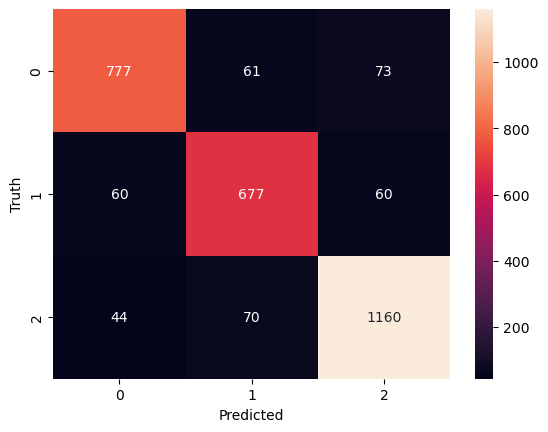

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       911
           1       0.84      0.85      0.84       797
           2       0.90      0.91      0.90      1274

    accuracy                           0.88      2982
   macro avg       0.87      0.87      0.87      2982
weighted avg       0.88      0.88      0.88      2982



In [42]:
m3 = best_classifier({'Random_Rorest': RandomForestClassifier(n_estimators=100)})

Desicion_Tree_Classifier
****************************************************************************************************
Score for Desicion_Tree_Classifier is: 0.8286584498229084


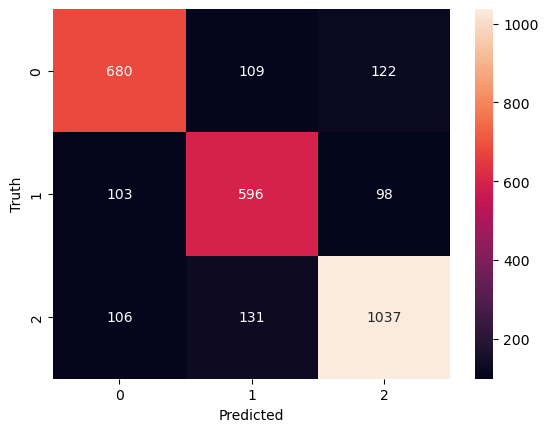

              precision    recall  f1-score   support

           0       0.76      0.75      0.76       911
           1       0.71      0.75      0.73       797
           2       0.82      0.81      0.82      1274

    accuracy                           0.78      2982
   macro avg       0.77      0.77      0.77      2982
weighted avg       0.78      0.78      0.78      2982



In [43]:
m4 = best_classifier({'Desicion_Tree_Classifier': DecisionTreeClassifier()})

MultinomialNB
****************************************************************************************************
Score for MultinomialNB is: 0.8601380217172911


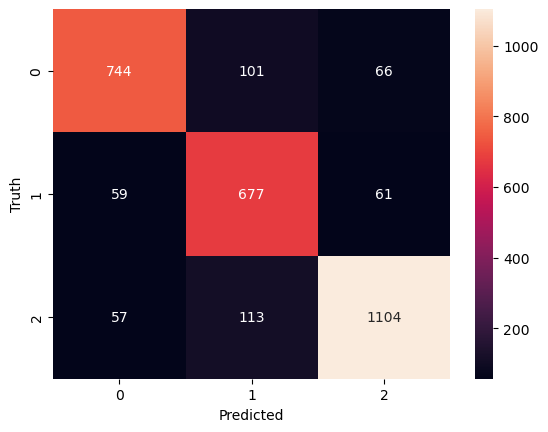

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       911
           1       0.76      0.85      0.80       797
           2       0.90      0.87      0.88      1274

    accuracy                           0.85      2982
   macro avg       0.84      0.84      0.84      2982
weighted avg       0.85      0.85      0.85      2982



In [44]:
m5 = best_classifier({'MultinomialNB': MultinomialNB()})

XGBoost
****************************************************************************************************
Score for XGBoost is: 0.8993424639216615


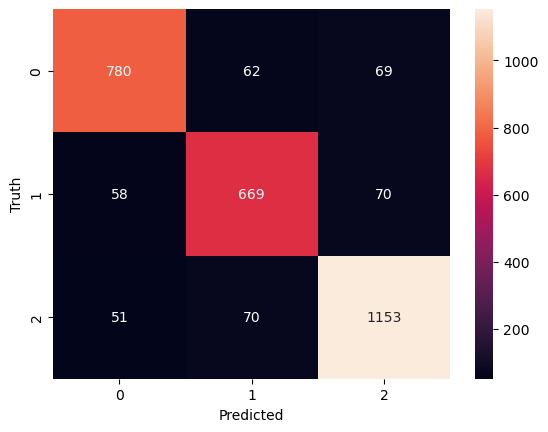

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       911
           1       0.84      0.84      0.84       797
           2       0.89      0.91      0.90      1274

    accuracy                           0.87      2982
   macro avg       0.87      0.87      0.87      2982
weighted avg       0.87      0.87      0.87      2982



In [45]:
m6 = best_classifier({'XGBoost': XGBClassifier()})

In [46]:
m2.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Hyperparameter Tuning to increase performance further more

In [47]:
model_params={'SVM':{
    'model': SVC(),
    'params': {
        'C':[0.1,1,10,20],
        'gamma':['auto','scale',0.1,1.0],
        'kernel':['linear', 'poly', 'rbf', 'sigmoid']  
    }
}
             }

In [48]:
score=[]

for mn,mp in model_params.items():
    clf = GridSearchCV(mp['model'],mp['params'],cv = 10,return_train_score=False)
    clf.fit(X_train_resampled, y_train_resampled)
    
    score.append({'model':mn,
                 'best_params':clf.best_params_,
                 'best_score':clf.best_score_,
                 })


In [49]:
score

[{'model': 'SVM',
  'best_params': {'C': 20, 'gamma': 1.0, 'kernel': 'rbf'},
  'best_score': 0.9365827410279884}]

SVM
****************************************************************************************************
Score for SVM is: 0.9344885430488554


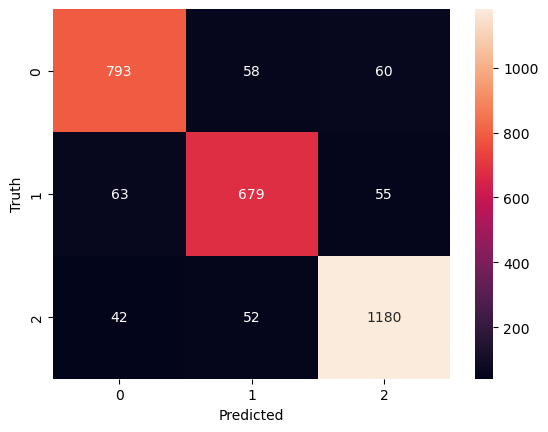

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       911
           1       0.86      0.85      0.86       797
           2       0.91      0.93      0.92      1274

    accuracy                           0.89      2982
   macro avg       0.88      0.88      0.88      2982
weighted avg       0.89      0.89      0.89      2982



In [72]:
model_final = best_classifier({'SVM': SVC(C=20,gamma=1.0,kernel='rbf', probability=True)})

# Model Testing

In [73]:
skills = ['python, machine learning, statistics, deep learning',
         'sql,excel,power bi',
         'spark,big data,aws,scala']

In [74]:
skills_cv = cv.transform(skills)

skills_tfidf = tfidf.transform(skills_cv)

In [75]:
model_final.predict(skills_tfidf)

array([0, 1, 2], dtype=int64)

In [83]:
np.round(model_final.predict_proba(skills_tfidf),2)

array([[1.  , 0.  , 0.  ],
       [0.01, 0.99, 0.  ],
       [0.  , 0.01, 0.99]])